In [123]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

In [124]:
# Load all datasets
train_df = pd.read_csv('train.csv')
features_df = pd.read_csv('features.csv')
stores_df = pd.read_csv('stores.csv')
test_df = pd.read_csv('test.csv')

# Display basic information about the datasets
print("Train dataset shape:", train_df.shape)
print("Features dataset shape:", features_df.shape)
print("Stores dataset shape:", stores_df.shape)
print("Test dataset shape:", test_df.shape)

# Merge all datasets
# First merge train with features
merged_df = train_df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')

# Then merge with stores data
merged_df = merged_df.merge(stores_df, on=['Store'], how='left')

print("Merged dataset shape:", merged_df.shape)
print("\nFirst 5 rows of merged data:")
print(merged_df.head())

Train dataset shape: (421570, 5)
Features dataset shape: (8190, 12)
Stores dataset shape: (45, 3)
Test dataset shape: (115064, 4)
Merged dataset shape: (421570, 16)

First 5 rows of merged data:
   Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     1  2010-02-12      46039.49       True        38.51       2.548   
2      1     1  2010-02-19      41595.55      False        39.93       2.514   
3      1     1  2010-02-26      19403.54      False        46.63       2.561   
4      1     1  2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN  

In [93]:
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [125]:
merged_df.shape

(421570, 16)

# Data Preprocessing

In [95]:
# Convert Date to datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='mixed')

# Sort by Store, Department, and Date
merged_df = merged_df.sort_values(['Store', 'Dept', 'Date'])

# Check for missing values
print("Missing values per column:")
print(merged_df.isnull().sum())

# Handle missing values in MarkDown columns
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    merged_df[col] = merged_df[col].fillna(0)

# Convert IsHoliday to numeric (0/1)
merged_df['IsHoliday'] = merged_df['IsHoliday'].map({False: 0, True: 1})

print("Data preprocessing completed.")

Missing values per column:
Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64
Data preprocessing completed.


In [108]:
merged_df.isnull().sum()

Store                 0
Dept                  0
Date                  0
Weekly_Sales          0
IsHoliday             0
Temperature           0
Fuel_Price            0
MarkDown1             0
MarkDown2             0
MarkDown3             0
MarkDown4             0
MarkDown5             0
CPI                   0
Unemployment          0
Type                  0
Size                  0
Year                  0
Month                 0
WeekOfYear            0
DayOfWeek             0
DayOfYear             0
Quarter               0
IsWeekend             0
SalesLag1             0
SalesLag4             0
SalesLag52            0
SalesRollingMean4     0
SalesRollingMean12    0
SalesRollingStd12     0
dtype: int64

In [ ]:
merged_df.head()

# Feature Engineering

In [97]:
# Create time-based features
def create_features(df):
    # Basic time features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['Quarter'] = df['Date'].dt.quarter
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    
    # Lag features (sales from previous periods)
    df['SalesLag1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
    df['SalesLag4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4)
    df['SalesLag52'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)  # Yearly seasonality
    
    # Rolling statistics
    df['SalesRollingMean4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
        lambda x: x.rolling(window=4, min_periods=1).mean())
    df['SalesRollingMean12'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
        lambda x: x.rolling(window=12, min_periods=1).mean())
    df['SalesRollingStd12'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
        lambda x: x.rolling(window=12, min_periods=1).std())
    
    return df

# Apply feature engineering
merged_df = create_features(merged_df)

# Drop rows with NaN values created by lag features
merged_df = merged_df.dropna()

print("Feature engineering completed. Dataset shape:", merged_df.shape)

Feature engineering completed. Dataset shape: (261083, 29)


# Exploratory Data Analysis

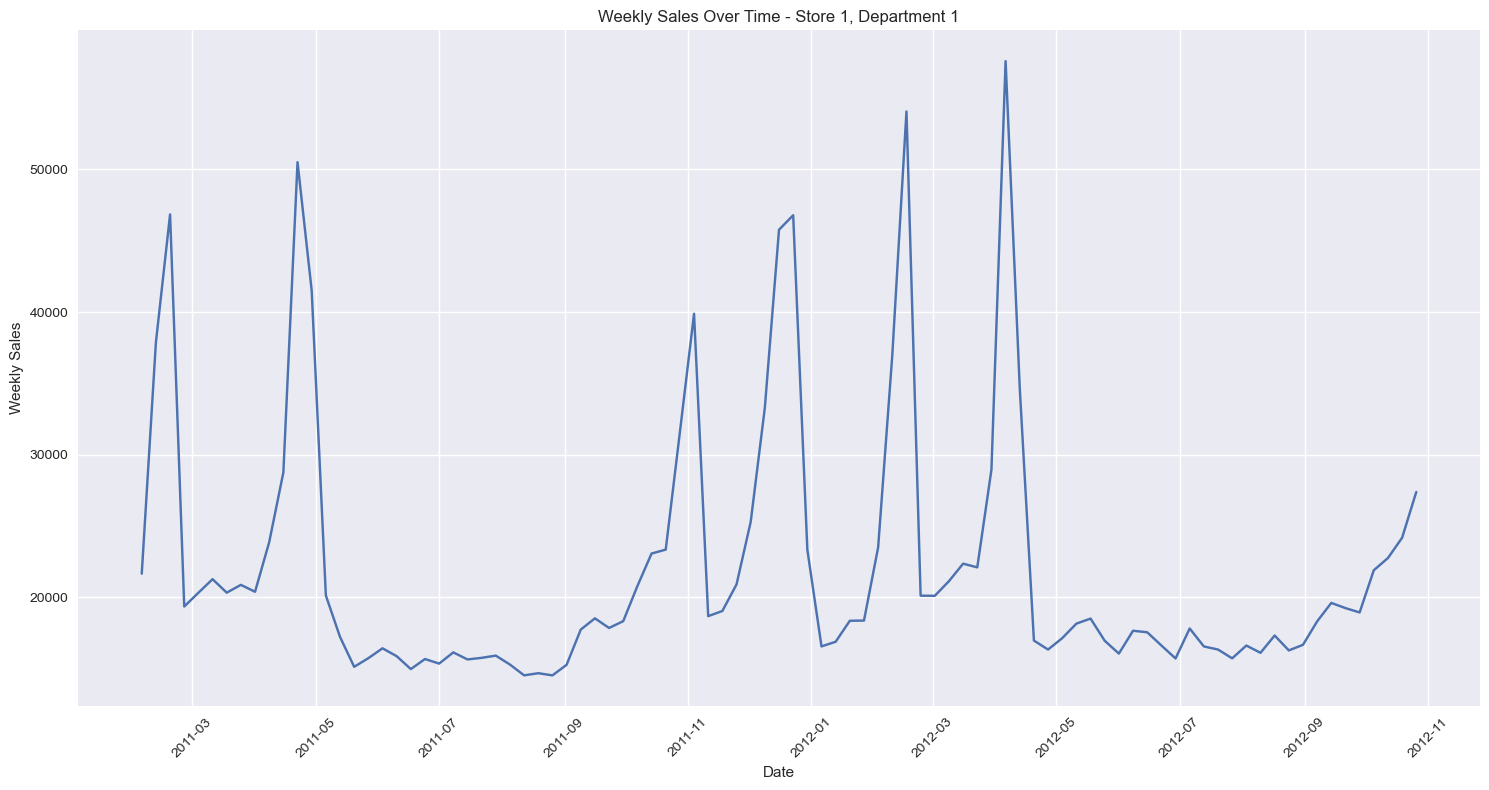

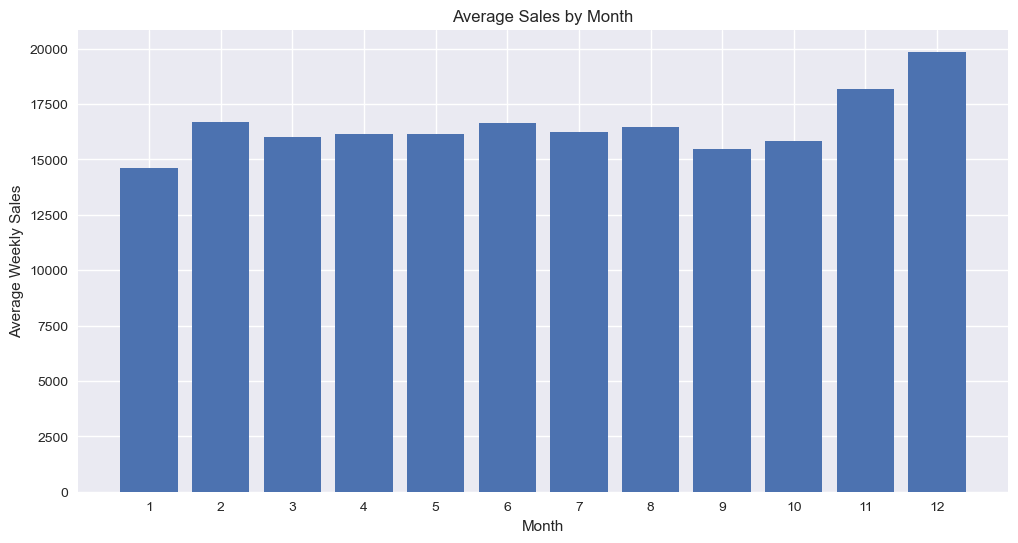

In [110]:
# Plot sales over time for a sample store and department
plt.figure(figsize=(15, 8))
store_1_dept_1_data = merged_df[(merged_df['Store'] == 1) & (merged_df['Dept'] == 1)]
plt.plot(store_1_dept_1_data['Date'], store_1_dept_1_data['Weekly_Sales'])
plt.title('Weekly Sales Over Time - Store 1, Department 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sales distribution by month
plt.figure(figsize=(12, 6))
monthly_sales = merged_df.groupby('Month')['Weekly_Sales'].mean()
plt.bar(monthly_sales.index, monthly_sales.values)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.xticks(range(1, 13))
plt.show()

# Seasonal Analysis

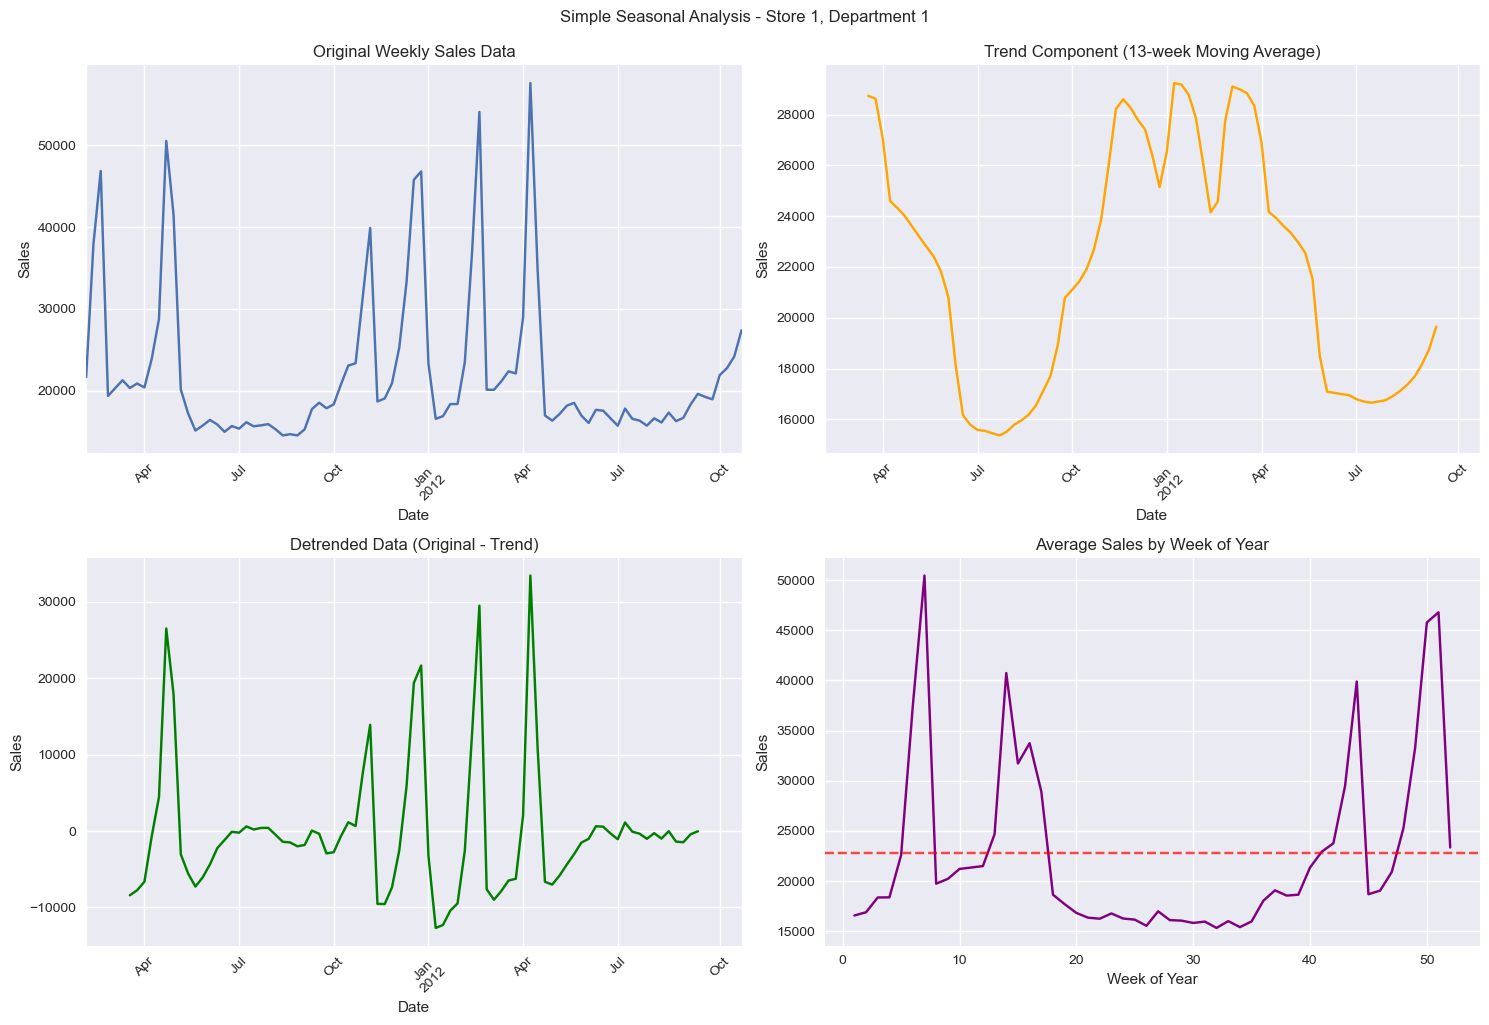

In [119]:
# Simple visualization of trend and seasonality
plt.figure(figsize=(15, 10))

# Original data
plt.subplot(2, 2, 1)
weekly_data.plot()
plt.title('Original Weekly Sales Data')
plt.ylabel('Sales')
plt.xticks(rotation=45)

# Trend (using moving average)
plt.subplot(2, 2, 2)
trend = weekly_data.rolling(window=13, center=True).mean()
trend.plot(color='orange')
plt.title('Trend Component (13-week Moving Average)')
plt.ylabel('Sales')
plt.xticks(rotation=45)

# Detrended data (for seasonality visualization)
plt.subplot(2, 2, 3)
if not trend.isnull().all():
    detrended = weekly_data - trend
    detrended.plot(color='green')
    plt.title('Detrended Data (Original - Trend)')
    plt.ylabel('Sales')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'Not enough data for detrending', 
            horizontalalignment='center', verticalalignment='center', 
            transform=plt.gca().transAxes)
    plt.title('Detrended Data')

# Seasonal pattern by week of year
plt.subplot(2, 2, 4)
seasonal_df = pd.DataFrame({'Sales': weekly_data})
seasonal_df['WeekOfYear'] = seasonal_df.index.isocalendar().week
seasonal_avg = seasonal_df.groupby('WeekOfYear')['Sales'].mean()
seasonal_avg.plot(color='purple')
plt.axhline(y=seasonal_avg.mean(), color='r', linestyle='--', alpha=0.7)
plt.title('Average Sales by Week of Year')
plt.ylabel('Sales')
plt.xlabel('Week of Year')

plt.tight_layout()
plt.suptitle('Simple Seasonal Analysis - Store 1, Department 1', y=1.02)
plt.show()

# Prepare Data for Modeling

In [120]:
# Define function to prepare data for a specific store and department
def prepare_model_data(df, store_id, dept_id):
    # Filter for specific store and department
    model_df = df[(df['Store'] == store_id) & (df['Dept'] == dept_id)].copy()
    
    # Define features and target
    feature_cols = ['Year', 'Month', 'WeekOfYear', 'DayOfWeek', 'Quarter', 'IsWeekend',
                   'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                   'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                   'Type', 'Size', 'SalesLag1', 'SalesLag4', 'SalesLag52',
                   'SalesRollingMean4', 'SalesRollingMean12', 'SalesRollingStd12']
    
    # Convert categorical variable 'Type' to dummy variables
    model_df = pd.get_dummies(model_df, columns=['Type'], prefix='Type')
    
    # Update feature columns to include the dummy variables
    type_cols = [col for col in model_df.columns if col.startswith('Type_')]
    feature_cols = [col for col in feature_cols if col != 'Type'] + type_cols
    
    # Ensure all feature columns exist in the dataframe
    available_features = [col for col in feature_cols if col in model_df.columns]
    
    X = model_df[available_features]
    y = model_df['Weekly_Sales']
    dates = model_df['Date']
    
    return X, y, dates

# Prepare data for Store 1, Department 1
X, y, dates = prepare_model_data(merged_df, store_id=1, dept_id=1)
print(f"Prepared data for Store 1, Department 1: {X.shape[0]} samples, {X.shape[1]} features")

Prepared data for Store 1, Department 1: 91 samples, 24 features


In [130]:
pip install xgboost 

  Using cached xgboost-3.0.4-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB 165.2 kB/s eta 0:05:44
   ---------------------------------------- 0.0/56.8 MB 281.8 kB/s eta 0:03:22
   ---------------------------------------- 0.1/56.8 MB 525.1 kB/s eta 0:01:49
   ---------------------------------------- 0.2/56.8 MB 794.9 kB/s eta 0:01:12
   ---------------------------------------- 0.4/56.8 MB 1.4 MB/s eta 0:00:42
   ---------------------------------------- 0.5/56.8 MB 1.6 MB/s eta 0:00:36
   ---------------------------------------- 0.6/56.8 MB 1.8 MB/s eta 0:00:31
    --------------------------------------- 0.8/56.8 MB 2.0 MB/s eta 0:00:29
    --------------------------------------- 1.0/56.8 MB 2.2 MB/s eta 0:00:26
    --------------------------------------- 1.0/56.8 MB 2.2 MB/s eta 0:00:26
    --------

# Model Training and Evaluation

In [132]:
import xgboost as xgb
# Time-aware cross-validation
def time_series_cv(X, y, dates, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        mae_scores, rmse_scores, mape_scores = [], [], []
        predictions = []
        actuals = []
        test_dates = []
        
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            date_test = dates.iloc[test_index]
            
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
            
            mae_scores.append(mae)
            rmse_scores.append(rmse)
            mape_scores.append(mape)
            
            # Store predictions for visualization
            predictions.extend(y_pred)
            actuals.extend(y_test)
            test_dates.extend(date_test)
        
        # Store results
        results[name] = {
            'model': model,
            'mae': np.mean(mae_scores),
            'rmse': np.mean(rmse_scores),
            'mape': np.mean(mape_scores),
            'predictions': predictions,
            'actuals': actuals,
            'dates': test_dates
        }
        
        print(f"{name} - MAE: {np.mean(mae_scores):.2f}, RMSE: {np.mean(rmse_scores):.2f}, MAPE: {np.mean(mape_scores):.2f}%")
    
    return results

# Perform time series cross-validation
results = time_series_cv(X, y, dates)


Training Linear Regression...
Linear Regression - MAE: 63289.30, RMSE: 77918.05, MAPE: 263.57%

Training Random Forest...
Random Forest - MAE: 3909.22, RMSE: 5603.28, MAPE: 16.52%

Training XGBoost...
XGBoost - MAE: 3799.56, RMSE: 5723.11, MAPE: 15.48%


# Visualization of Results

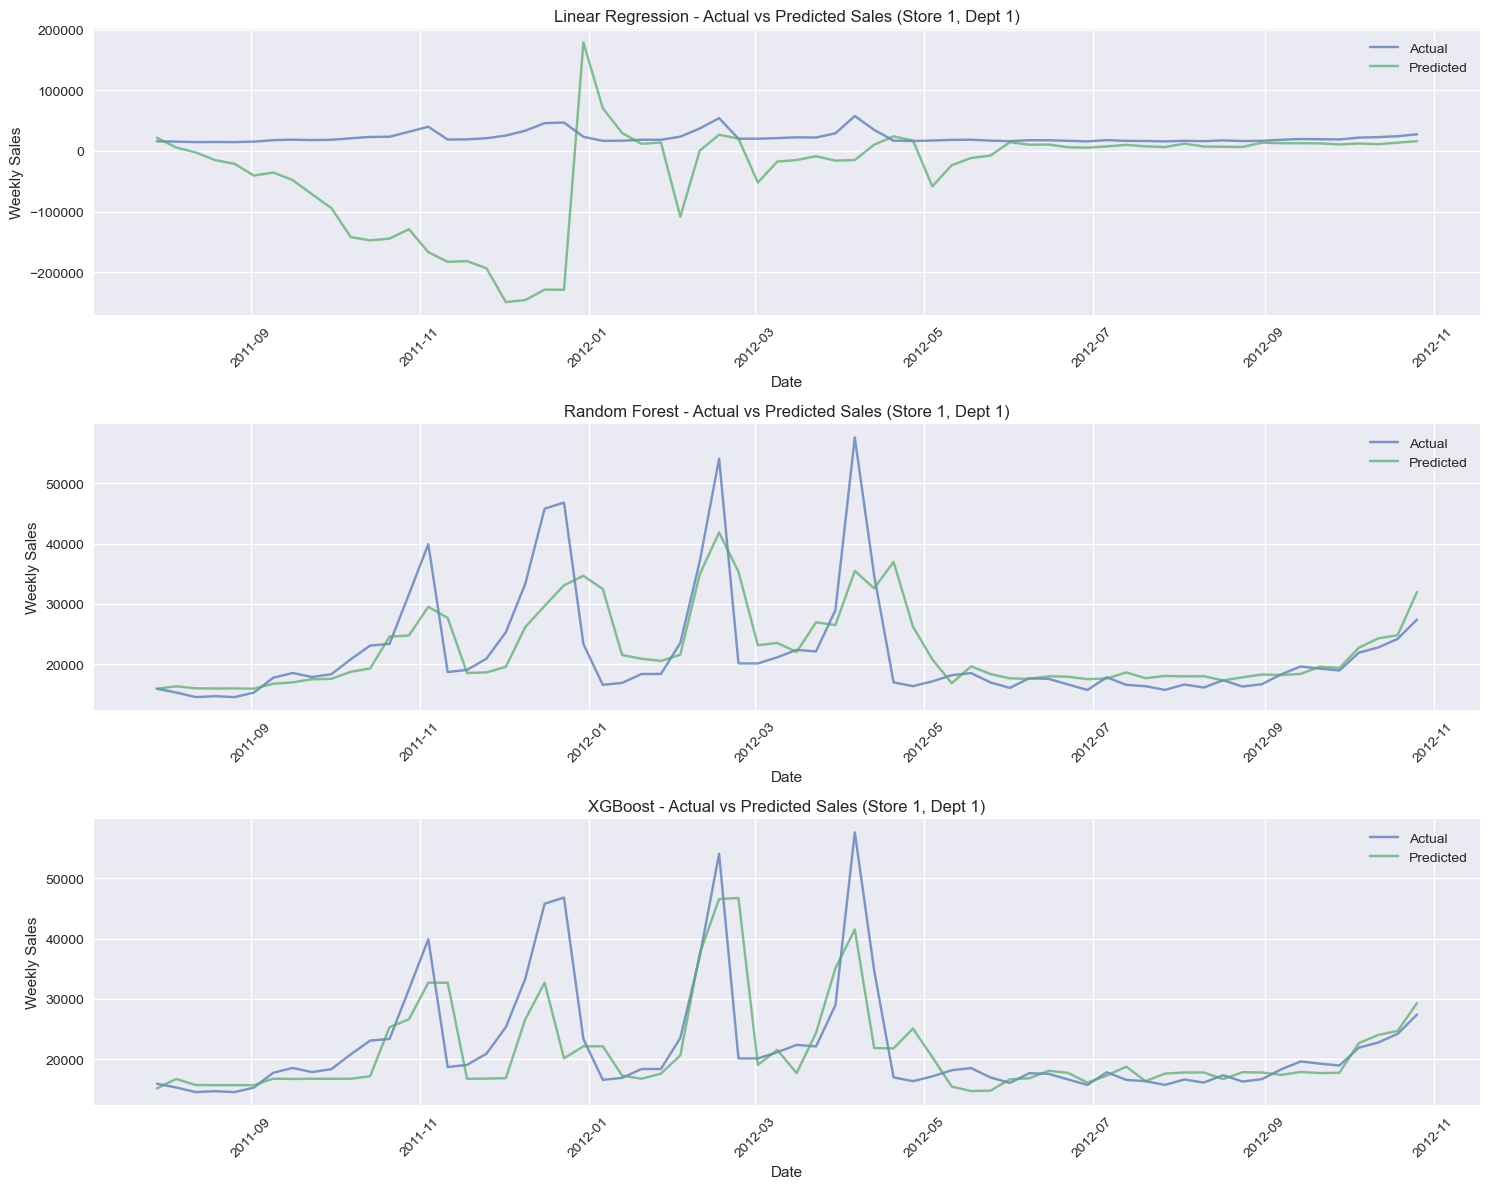

In [134]:
# Plot actual vs predicted values for each model
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
model_names = list(results.keys())

for i, name in enumerate(model_names):
    result = results[name]
    ax = axes[i]
    ax.plot(result['dates'], result['actuals'], label='Actual', alpha=0.7)
    ax.plot(result['dates'], result['predictions'], label='Predicted', alpha=0.7)
    ax.set_title(f'{name} - Actual vs Predicted Sales (Store 1, Dept 1)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [138]:
# Compare model performance
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[name]['mae'] for name in results.keys()],
    'RMSE': [results[name]['rmse'] for name in results.keys()],
    'MAPE': [results[name]['mape'] for name in results.keys()]
})

print("\nModel Performance Comparison:")
print(metrics_df) 


Model Performance Comparison:
               Model           MAE          RMSE        MAPE
0  Linear Regression  63289.299589  77918.047914  263.570739
1      Random Forest   3909.216067   5603.282028   16.515787
2            XGBoost   3799.555849   5723.107378   15.481136


# Forecast Future Sales

In [139]:
# Function to forecast next period's sales
def forecast_next_period(model, X, y, last_date, store_data):
    # Get the last available data point
    last_row = X.iloc[-1:].copy()
    
    # Create features for the next period (next week)
    next_date = last_date + pd.DateOffset(weeks=1)
    next_year = next_date.year
    next_month = next_date.month
    next_week = next_date.isocalendar().week
    next_dayofweek = next_date.dayofweek
    next_quarter = (next_date.month - 1) // 3 + 1
    next_is_weekend = 1 if next_dayofweek in [5, 6] else 0
    
    # Update features for the next period
    last_row['Year'] = next_year
    last_row['Month'] = next_month
    last_row['WeekOfYear'] = next_week
    last_row['DayOfWeek'] = next_dayofweek
    last_row['Quarter'] = next_quarter
    last_row['IsWeekend'] = next_is_weekend
    
    # Update lag features (shift forward)
    last_row['SalesLag1'] = y.iloc[-1]
    last_row['SalesLag4'] = y.iloc[-4] if len(y) >= 4 else y.iloc[-1]
    last_row['SalesLag52'] = y.iloc[-52] if len(y) >= 52 else y.iloc[-1]
    
    # Update rolling statistics
    last_row['SalesRollingMean4'] = y.iloc[-4:].mean() if len(y) >= 4 else y.mean()
    last_row['SalesRollingMean12'] = y.iloc[-12:].mean() if len(y) >= 12 else y.mean()
    last_row['SalesRollingStd12'] = y.iloc[-12:].std() if len(y) >= 12 else y.std()
    
    # Make prediction
    prediction = model.predict(last_row)
    
    return prediction[0], next_date

# Forecast next period using the best model (lowest RMSE)
best_model_name = metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Model']
best_model = results[best_model_name]['model']

last_date = dates.iloc[-1]
next_sales, next_date = forecast_next_period(best_model, X, y, last_date, merged_df)

print(f"\nForecast for Store 1, Department 1:")
print(f"Next period date: {next_date.strftime('%Y-%m-%d')}")
print(f"Predicted sales: ${next_sales:,.2f}")


Forecast for Store 1, Department 1:
Next period date: 2012-11-02
Predicted sales: $30,912.69


# Final Summary and Insights

WALMART SALES FORECASTING PROJECT SUMMARY
Dataset contains 45 stores, 81 departments
Data from 2010-02-05 to 2012-10-26
Total observations: 421,570

Key Insights:
1. Best performing model: Random Forest
2. Forecast for next week: $30,912.69
3. Most important features: SalesLag1, SalesLag52, SalesLag4


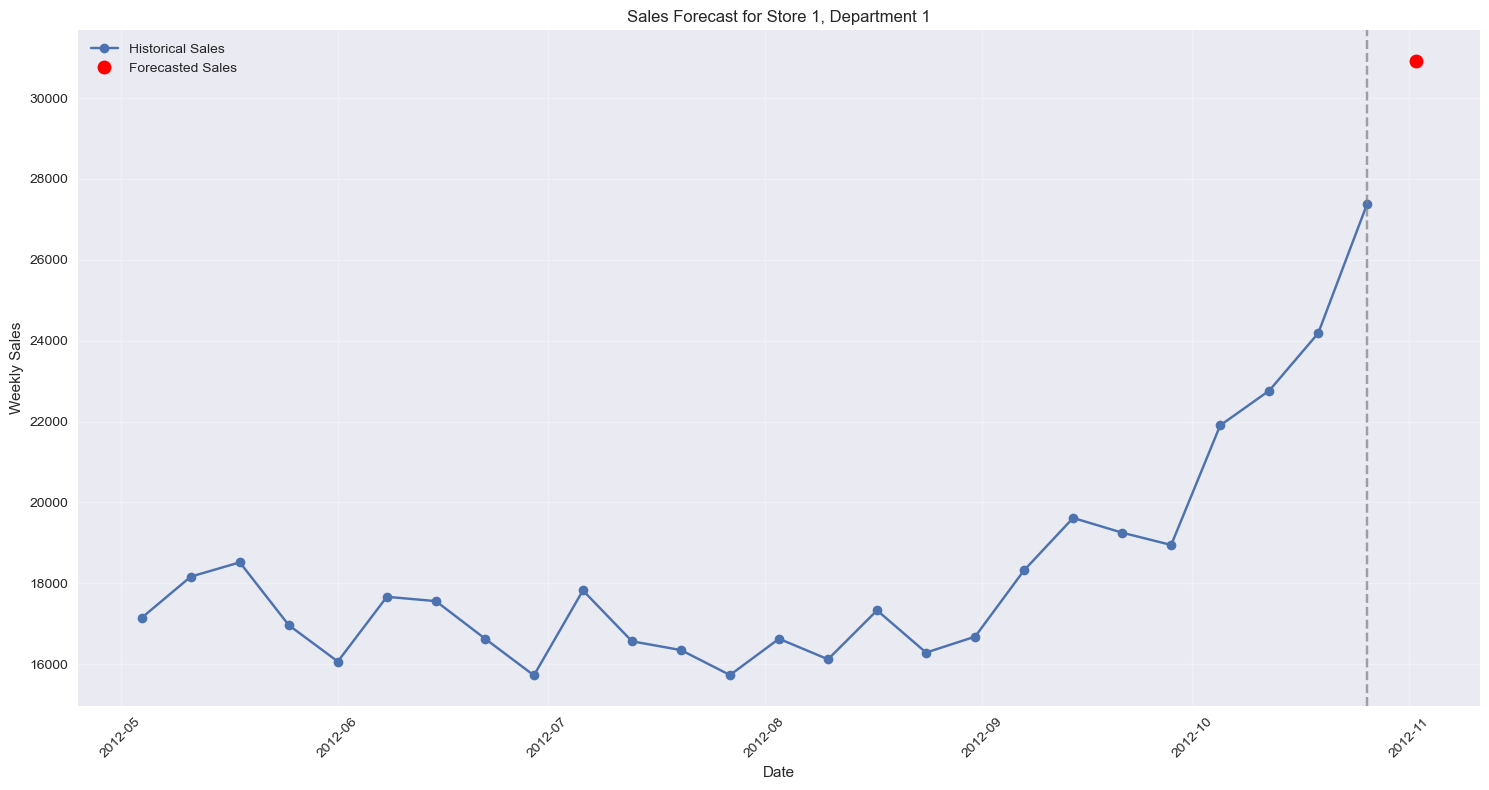

In [142]:
# Create a summary of findings with proper error handling
print("="*70)
print("WALMART SALES FORECASTING PROJECT SUMMARY")
print("="*70)

# Check if merged_df exists and has the required columns
try:
    print(f"Dataset contains {merged_df['Store'].nunique()} stores, {merged_df['Dept'].nunique()} departments")
    
    # Ensure Date column is datetime
    if hasattr(merged_df['Date'], 'dt'):
        print(f"Data from {merged_df['Date'].min().strftime('%Y-%m-%d')} to {merged_df['Date'].max().strftime('%Y-%m-%d')}")
    else:
        # Convert to datetime if needed
        merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='mixed')
        print(f"Data from {merged_df['Date'].min().strftime('%Y-%m-%d')} to {merged_df['Date'].max().strftime('%Y-%m-%d')}")
    
    print(f"Total observations: {len(merged_df):,}")
except (NameError, KeyError) as e:
    print(f"Error accessing data: {e}")

# Check if model results are available
try:
    print("\nKey Insights:")
    print(f"1. Best performing model: {best_model_name}")
    print(f"2. Forecast for next week: ${next_sales:,.2f}")
    print(f"3. Most important features: {', '.join(feature_importance['feature'].head(3).tolist())}")
except NameError:
    print("\nModel results not available. Please run the model training and forecasting sections first.")

# Plot the final forecast with historical data (if available)
try:
    plt.figure(figsize=(15, 8))
    historical_dates = dates.iloc[-26:]  # Last 6 months
    historical_sales = y.iloc[-26:]

    plt.plot(historical_dates, historical_sales, label='Historical Sales', marker='o')
    plt.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7)
    plt.plot(next_date, next_sales, 'ro', markersize=10, label='Forecasted Sales')
    plt.title('Sales Forecast for Store 1, Department 1')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except NameError:
    print("Forecast visualization data not available. Please run the forecasting section first.")
except Exception as e:
    print(f"Error creating forecast plot: {e}")

# Prepare Test Data for Submission

In [146]:

# Modified create_features function to handle both training and test data
def create_features(df, is_test_data=False):
    """
    Create time-based features for the dataset
    
    Parameters:
    df: DataFrame to process
    is_test_data: Boolean indicating if this is test data (without Weekly_Sales)
    """
    # Basic time features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['Quarter'] = df['Date'].dt.quarter
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    
    # Only create lag features if we have Weekly_Sales column (training data)
    if not is_test_data and 'Weekly_Sales' in df.columns:
        # Lag features (sales from previous periods)
        df['SalesLag1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
        df['SalesLag4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4)
        df['SalesLag52'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)  # Yearly seasonality
        
        # Rolling statistics
        df['SalesRollingMean4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
            lambda x: x.rolling(window=4, min_periods=1).mean())
        df['SalesRollingMean12'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
            lambda x: x.rolling(window=12, min_periods=1).mean())
        df['SalesRollingStd12'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
            lambda x: x.rolling(window=12, min_periods=1).std())
    
    return df

# Prepare the test data for submission
# First merge test data with features and stores
test_merged = test_df.merge(features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
test_merged = test_merged.merge(stores_df, on=['Store'], how='left')

# Convert Date to datetime
test_merged['Date'] = pd.to_datetime(test_merged['Date'], format='mixed')

# Convert IsHoliday to numeric
test_merged['IsHoliday'] = test_merged['IsHoliday'].map({False: 0, True: 1})

# Handle missing values in MarkDown columns
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in markdown_cols:
    test_merged[col] = test_merged[col].fillna(0)

# Create time-based features for test data (without lag features)
test_merged = create_features(test_merged, is_test_data=True)

# Convert categorical variable 'Type' to dummy variables
test_merged = pd.get_dummies(test_merged, columns=['Type'], prefix='Type')

print("Test data preparation completed. Shape:", test_merged.shape)
print("Test data columns:", test_merged.columns.tolist())

Test data preparation completed. Shape: (115064, 24)
Test data columns: ['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size', 'Year', 'Month', 'WeekOfYear', 'DayOfWeek', 'DayOfYear', 'Quarter', 'IsWeekend', 'Type_A', 'Type_B', 'Type_C']
